In [ ]:
# Cell 1: Import Libraries & Mount Drive
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# Mount Google Drive
drive.mount('/content/drive')

# --- UPDATE THIS PATH ---
DATASET_PATH = '/content/drive/MyDrive/PlantVillage'
print("✅ Libraries imported and Drive mounted!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Libraries imported and Drive mounted!


In [ ]:
# Cell 2: Data Loading & Preprocessing
print("Loading images... This may take a minute.")

data = []
labels = []
classes = os.listdir(DATASET_PATH)
classes = [c for c in classes if not c.startswith('.')] # Ignore hidden files

IMG_SIZE = 128
MAX_IMAGES = 100 # Limit for speed

for category in classes:
    path = os.path.join(DATASET_PATH, category)
    class_num = classes.index(category)

    count = 0
    if not os.path.isdir(path): continue

    for img_name in os.listdir(path):
        if count >= MAX_IMAGES: break
        try:
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            if img is None: continue

            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            labels.append(class_num)
            count += 1
        except Exception as e:
            pass
    print(f"Loaded {count} images for class: {category}")

# Convert to NumPy Arrays & Normalize
X = np.array(data)
y = np.array(labels)
X = X / 255.0

print(f"✅ Data Ready. Total Images: {len(X)}")
print(f"Shape: {X.shape}")

Loading images... This may take a minute.
Loaded 100 images for class: Tomato__Tomato_mosaic_virus
Loaded 100 images for class: Tomato__Tomato_YellowLeaf__Curl_Virus
Loaded 100 images for class: Tomato_Septoria_leaf_spot
Loaded 100 images for class: Tomato_Leaf_Mold
Loaded 100 images for class: Tomato__Target_Spot
Loaded 100 images for class: Tomato_healthy
Loaded 100 images for class: Tomato_Spider_mites_Two_spotted_spider_mite
Loaded 100 images for class: Tomato_Bacterial_spot
Loaded 100 images for class: Tomato_Late_blight
Loaded 0 images for class: Tomato_Early_blight
Loaded 0 images for class: Potato___Late_blight
Loaded 0 images for class: PlantVillage
Loaded 0 images for class: Potato___healthy
Loaded 0 images for class: Pepper__bell___healthy
Loaded 0 images for class: Potato___Early_blight
Loaded 0 images for class: Pepper__bell___Bacterial_spot
✅ Data Ready. Total Images: 900
Shape: (900, 128, 128, 3)


In [ ]:
# Cell 3: Train Standard ML Models
print("--- Phase 1: Training Standard ML Models ---")

# Flatten images for ML models
X_flat = X.reshape(len(X), -1)

# Split Data
X_train_ml, X_test_ml, y_train_ml, y_test_ml = train_test_split(X_flat, y, test_size=0.2, random_state=42)

# Define Models
# We use a dictionary to store the TRAINED models
trained_models = {}
results = {}

models_to_train = {
    "SVM": SVC(kernel='rbf', C=10),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

for name, model in models_to_train.items():
    print(f"Training {name}...")
    model.fit(X_train_ml, y_train_ml)
    preds = model.predict(X_test_ml)
    acc = accuracy_score(y_test_ml, preds) * 100

    results[name] = acc
    trained_models[name] = model # Save the model for later
    print(f"  -> {name} Accuracy: {acc:.2f}%")

print("✅ Phase 1 Complete.")

--- Phase 1: Training Standard ML Models ---
Training SVM...
  -> SVM Accuracy: 75.56%
Training Random Forest...
  -> Random Forest Accuracy: 61.67%
Training KNN...
  -> KNN Accuracy: 45.56%
✅ Phase 1 Complete.


In [ ]:
# Cell 4: Train CNN Model
print("--- Phase 2: Training CNN Model ---")

X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X, y, test_size=0.2, random_state=42)

EPOCHS = 10

cnn_model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(classes), activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print(f"Training for {EPOCHS} epochs...")
history = cnn_model.fit(X_train_cnn, y_train_cnn, epochs=EPOCHS,
                        validation_data=(X_test_cnn, y_test_cnn), verbose=1)

# Save result
cnn_acc = history.history['val_accuracy'][-1] * 100
results["CNN (Proposed)"] = cnn_acc
trained_models["CNN (Proposed)"] = cnn_model

print(f"✅ Phase 2 Complete. CNN Accuracy: {cnn_acc:.2f}%")

--- Phase 2: Training CNN Model ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training for 10 epochs...
Epoch 1/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 776ms/step - accuracy: 0.1159 - loss: 3.2643 - val_accuracy: 0.1500 - val_loss: 2.1558
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 749ms/step - accuracy: 0.2744 - loss: 2.0055 - val_accuracy: 0.3722 - val_loss: 1.6325
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 741ms/step - accuracy: 0.4993 - loss: 1.4182 - val_accuracy: 0.5000 - val_loss: 1.3407
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 729ms/step - accuracy: 0.6963 - loss: 0.9854 - val_accuracy: 0.6111 - val_loss: 1.0047
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 750ms/step - accuracy: 0.7329 - loss: 0.7917 - val_accuracy: 0.6556 - val_loss: 0.9463
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 755ms/step - accuracy: 0.8237 - loss: 0.5335 - val_accuracy: 0.6944 - val_loss: 0.9059
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 22s 830ms/step - accuracy: 0.8509 - loss: 0.4657 - val_accuracy: 0.6444 - val_loss: 0.9530
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 736ms/step - accuracy: 0.9273


   🏆 FINAL LEADERBOARD 🏆
         Model  Accuracy (%)
           SVM     75.555556
CNN (Proposed)     72.222221
 Random Forest     61.666667
           KNN     45.555556

✅ CONCLUSION: The best model is 'SVM' with 75.56% accuracy.


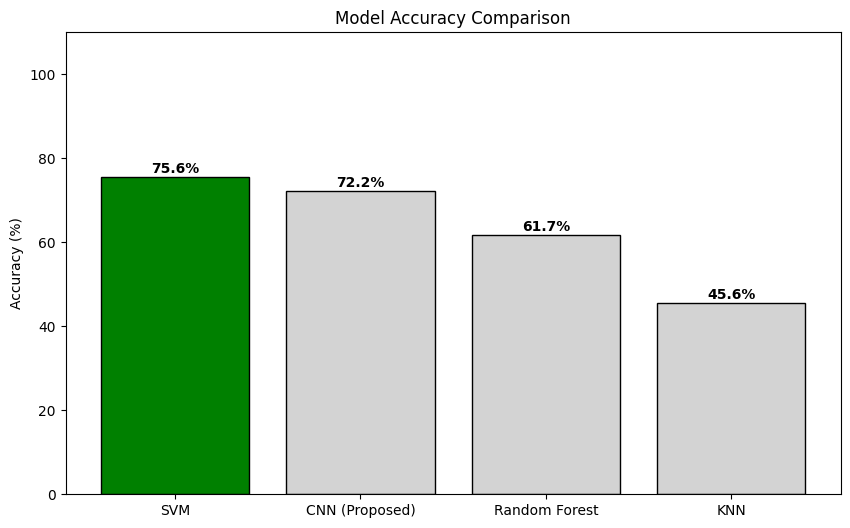

In [ ]:
# Cell 5: Comparison Table
df_results = pd.DataFrame(list(results.items()), columns=['Model', 'Accuracy (%)'])
df_results = df_results.sort_values(by='Accuracy (%)', ascending=False).reset_index(drop=True)

print("\n" + "="*40)
print("   🏆 FINAL LEADERBOARD 🏆")
print("="*40)
print(df_results.to_string(index=False))
print("="*40)

# Identify the winner
winner_name = df_results.iloc[0]['Model']
winner_acc = df_results.iloc[0]['Accuracy (%)']
print(f"\n✅ CONCLUSION: The best model is '{winner_name}' with {winner_acc:.2f}% accuracy.")

# Plot
plt.figure(figsize=(10, 6))
colors = ['green' if x == winner_acc else 'lightgray' for x in df_results['Accuracy (%)']]
bars = plt.bar(df_results['Model'], df_results['Accuracy (%)'], color=colors, edgecolor='black')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f"{yval:.1f}%", ha='center', fontweight='bold')

plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 110)
plt.show()

Generating detailed analysis for winner: SVM...


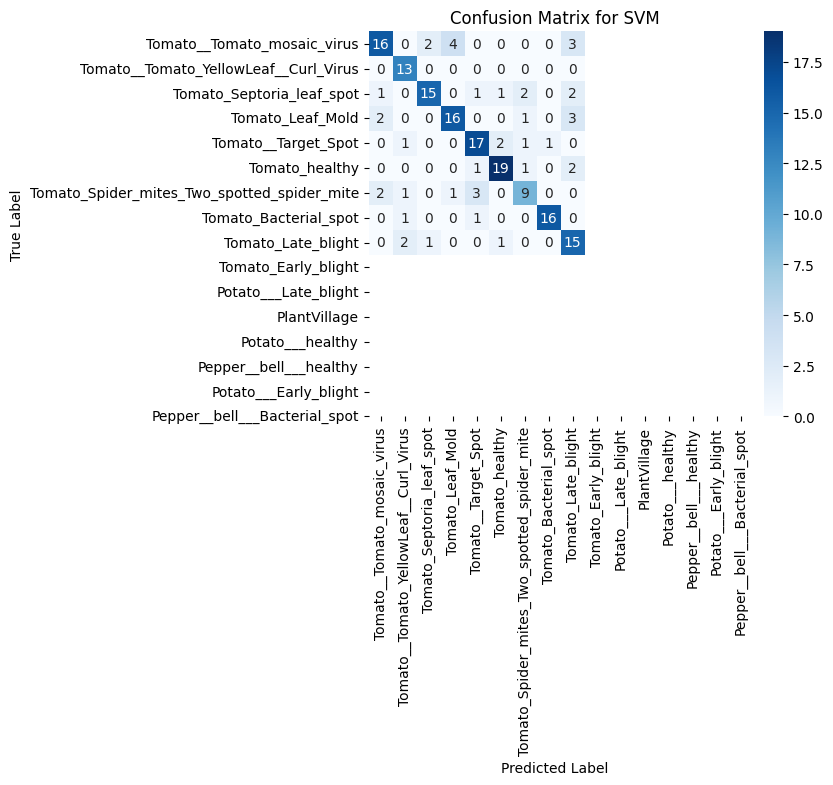

NOTE: Since an ML model (SVM/RF) won, we visualize the Confusion Matrix instead of Epoch history.


In [ ]:
# Cell 6: Detailed Analysis (Adaptive)
print(f"Generating detailed analysis for winner: {winner_name}...")

if "CNN" in winner_name:
    # --- IF CNN WINS: Show Loss Curves ---
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

else:
    # --- IF SVM/ML WINS: Show Confusion Matrix ---
    # Get predictions from the winning model
    model = trained_models[winner_name]
    y_pred = model.predict(X_test_ml)

    cm = confusion_matrix(y_test_ml, y_pred)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {winner_name}')
    plt.show()

    print("NOTE: Since an ML model (SVM/RF) won, we visualize the Confusion Matrix instead of Epoch history.")

🧐 Testing with the Winner Model: SVM


Saving 0a9b3ff4-5343-4814-ac2c-fdb3613d4e4d___Crnl_L.Mold 6559.JPG to 0a9b3ff4-5343-4814-ac2c-fdb3613d4e4d___Crnl_L.Mold 6559.JPG


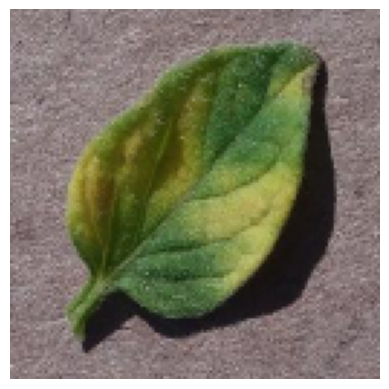


🌱 PREDICTION: Tomato_Leaf_Mold
⚠️ Status: Disease Detected.
💡 Recommendation: Apply appropriate fungicide and isolate the plant.


In [ ]:

from google.colab import files
from tensorflow.keras.preprocessing import image

print(f"🧐 Testing with the Winner Model: {winner_name}")
uploaded = files.upload()
for fn in uploaded.keys():

    path = fn
    img = cv2.imread(path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    img_normalized = img / 255.0

    if "CNN" in winner_name:

        img_input = np.expand_dims(img_normalized, axis=0)

        prediction = trained_models[winner_name].predict(img_input)
        predicted_class_index = np.argmax(prediction)
        confidence = np.max(prediction) * 100

    else:
        img_input = img_normalized.flatten().reshape(1, -1)
        predicted_class_index = trained_models[winner_name].predict(img_input)[0]
        confidence = 0.0
    result = classes[predicted_class_index]
    print(f"\n🌱 PREDICTION: {result}")
    if confidence > 0:
        print(f"📊 Confidence: {confidence:.2f}%")

    if "Healthy" in result:
        print("✅ Status: The plant is healthy! No action needed.")
    else:
        print("⚠️ Status: Disease Detected.")
        print("💡 Recommendation: Apply appropriate fungicide and isolate the plant.")

Generating Block Diagram...


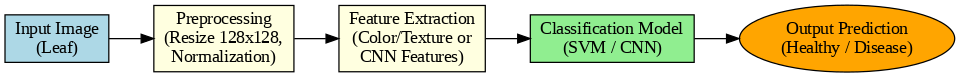

✅ Block diagram saved as 'project_block_diagram.png'. You can download it for your report.


In [ ]:
# Cell 8: Generate Block Diagram for Report
from graphviz import Digraph

# Create Digraph object
dot = Digraph(comment='Plant Disease Detection System')
dot.attr(rankdir='LR', size='10')

# Define Nodes (The boxes)
dot.node('A', 'Input Image\n(Leaf)', shape='rect', style='filled', fillcolor='lightblue')
dot.node('B', 'Preprocessing\n(Resize 128x128,\nNormalization)', shape='rect', style='filled', fillcolor='lightyellow')
dot.node('C', 'Feature Extraction\n(Color/Texture or\nCNN Features)', shape='rect', style='filled', fillcolor='lightyellow')
dot.node('D', 'Classification Model\n(SVM / CNN)', shape='rect', style='filled', fillcolor='lightgreen')
dot.node('E', 'Output Prediction\n(Healthy / Disease)', shape='ellipse', style='filled', fillcolor='orange')

# Define Edges (The arrows)
dot.edge('A', 'B')
dot.edge('B', 'C')
dot.edge('C', 'D')
dot.edge('D', 'E')

# Render and View
print("Generating Block Diagram...")
dot.render('project_block_diagram', format='png', view=False)

# Display in Notebook
from IPython.display import Image
display(Image('project_block_diagram.png'))
print("✅ Block diagram saved as 'project_block_diagram.png'. You can download it for your report.")

In [ ]:
# Save the model to a file
import pickle

# If SVM won:
if "CNN" not in winner_name:
    with open('plant_disease_model.pkl', 'wb') as f:
        pickle.dump(trained_models[winner_name], f)
    print("Saved SVM model as 'plant_disease_model.pkl'")

# If CNN won:
else:
    trained_models[winner_name].save('plant_disease_model.h5')
    print("Saved CNN model as 'plant_disease_model.h5'")

Saved SVM model as 'plant_disease_model.pkl'
